In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("embedded_summaries.csv")
df["ada_embedding_en"] = df["ada_embedding_en"].str.strip("[]").str.split(", ").apply(lambda x: np.asarray(x, dtype = np.float32))
df["ada_embedding_orig"] = df["ada_embedding_orig"].str.strip("[]").str.split(", ").apply(lambda x: np.asarray(x, dtype = np.float32))
df.head()

,title,summary,summaryEn,euCaselaw,euProvisions,eurovoc,ada_embedding_orig,ada_embedding_en
0,"Cass. Pen. sez. VI, 28/10/2022, no. 41102","In tema di mandato di arresto europeo, è onere...",The case is referred to the European arrest wa...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",[],"[-0.0055677397, 0.04387063, -0.003519325, 0.02...","[-0.028815685, 0.035505854, 0.030048685, 0.010..."
1,"Cass. Pen. sez F, 29/08/2023, n. 36397","In tema di mandato di arresto europeo, l'udien...",The case concerns the crime of driving without...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",[],"[-0.004492015, 0.031429846, 0.005390418, 0.022...","[-0.030826401, 0.03137465, 0.0049279877, -0.00..."
2,"Cass. Pen. sez. fer., 27/08/2020, n. 24593","L'art. 83, comma 12, L. n. 27 del 2020, pur de...",The case is referred to the European Arrest Wa...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",[],"[-0.009715813, 0.015775196, 0.0130383475, 0.05...","[-0.05120343, 0.026329726, 0.012728057, 0.0137..."
3,"Cassazione penale sez. VI, 30/10/2019, n. 49545",L'omessa trasmissione della traduzione in ling...,Failure to provide an Italian-language transla...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",[],"[-0.0053882697, 0.019800492, -0.00083434273, 0...","[-0.037508894, 0.019514915, 0.012245748, -0.00..."
4,"Cass. Pen. sez. VI, 15/09/2020, n.30885",Meri vizi formali afferenti la comunicazione n...,The case concerns the offences of illigal traf...,[],"[{'celex': '32014L0041', 'name': 'Directive 20...",[],"[0.077446036, 0.031979986, -0.0018669635, 0.04...","[-0.0110390335, 0.010701043, 0.000865348, 0.02..."


In [3]:
import numpy as np
import torch

from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
model = SentenceTransformer("../models/" + "paraphrase-multilingual-mpnet-base-v2").to(device)

cuda


/home/keddie/anaconda3/envs/facilex_caselaw/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
from tqdm import tqdm

sentence_embds = []
id_origs = []

for idx, text in tqdm(enumerate(df["summaryEn"].str.split(r"\.(?=[A-Z ])"))):
    embd = []
    for sentence in text:
        embd.append(model.encode(sentence.strip()))

    id_origs += [idx] * len(text)

    sentence_embds.append(np.asarray(embd))

69it [00:02, 28.38it/s]


In [8]:
sentence_embds = np.asarray([embd for embds in sentence_embds for embd in embds])
sentence_embds.shape

(259, 768)

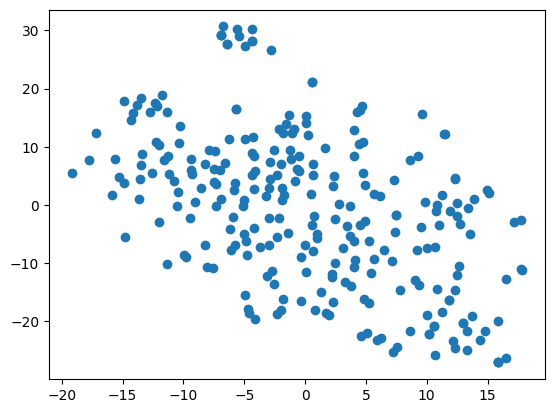

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(2)
tsne_data = tsne.fit_transform(sentence_embds)

plt.scatter(tsne_data[:,0], tsne_data[:,1])

In [11]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS

kmeans = KMeans(n_clusters = 4, n_init = "auto").fit(sentence_embds)
dbscan = DBSCAN().fit(sentence_embds)
optics = OPTICS().fit(sentence_embds)

df_sents = pd.DataFrame({"text": df["summaryEn"].str.split(r"\.(?=[A-Z ])").explode(), "id_orig": id_origs, "x": tsne_data[:,0], "y": tsne_data[:,1], "label_kmeans": kmeans.labels_, "label_dbscan": dbscan.labels_, "label_optics": optics.labels_})

In [12]:
df_sents[df_sents["label_kmeans"] == 2]["text"].reset_index(drop=True)

0       With regard to a minor who is older than 14 y...
1       This is based on the assumption that all memb...
2       The main fact relevant to the case is that th...
3       Against all these factors, the court conclude...
4       The main fact relevant to the case, that trig...
                             ...                        
105     For this procedure, Article 13 of the aforeme...
106     The Court added that, on the basis of Article...
107     69 of 2005, and of the shorter time limits co...
108     69 of 2005, the reference to these rules cont...
109     Applying this principle, the Court further sp...
Name: text, Length: 110, dtype: object

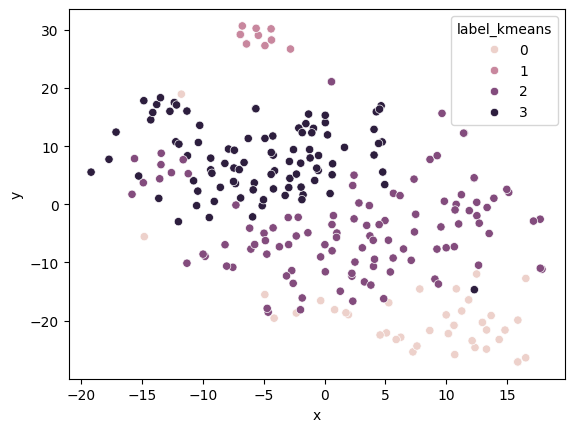

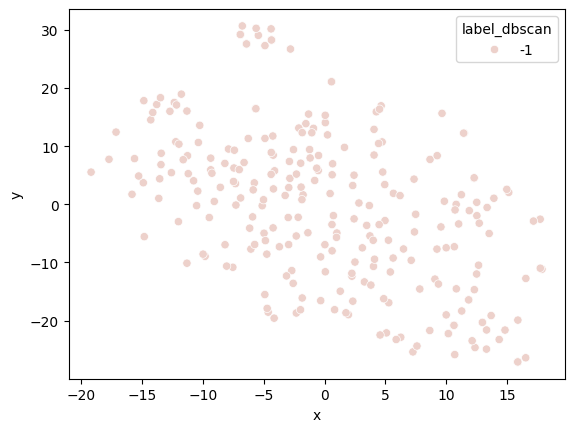

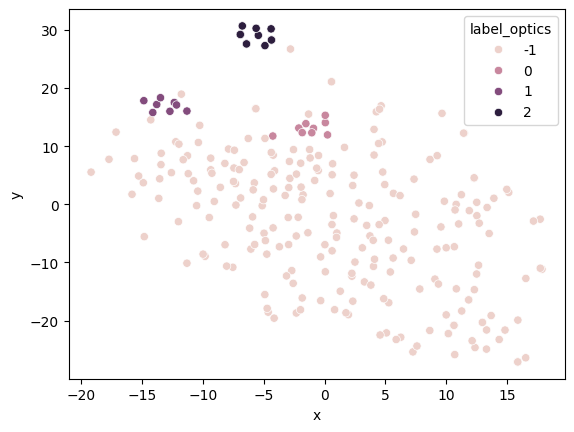

In [14]:
import seaborn as sns

for clustering_type in df_sents.columns[4:]:
    sns.scatterplot(data = df_sents, x = "x", y = "y", hue = clustering_type)
    plt.show()